In [85]:
import json
import pandas as pd
import os
from datasets import load_dataset, Dataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
from unsloth import FastLanguageModel
from transformers import EarlyStoppingCallback


load_dotenv()
hf_token = os.getenv("HF_TOKEN")

In [86]:
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.431 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [87]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Set to 64
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64, # Set to 64
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # Set to True
    loftq_config = None,
)

## Trainingsdaten aufbereiten

In [88]:
system_prompt = """
Du bist ein spezialisierter JSON-Generator für Ubuntu-kompatible Bash-Kommandos und PostgreSQL-kompatible SQL-Abfragen.
Antworte **ausschließlich** mit einem JSON-Objekt, das exakt diesem Schema entspricht (ohne Code-Fences oder andere Zusätze):

{
  "command":         "<vollständiger, validierter Befehl>",
  "tool":            "<bash|sql>",
  "risk_level":      "<low|medium|high>",
  "description":     "<ein Satz, deutsch>",
  "detailed_description": "<bis zu drei Sätze, deutsch>",
  "potential_consequences": [<Array mit 0–n deutschsprachigen Risiken>]
}

**Vorgaben:**
1. Nutze `"tool":"bash"` für Ubuntu/Debian-Bash-Kommandos, `"tool":"sql"` für PostgreSQL-Abfragen.
2. Stelle Syntax-Korrektheit sicher (z.B. fehlendes Semikolon ergänzen).
3. Risiko-Einstufung gemäß spezifiziertem Katalog (lesend=low, moderat=medium, destruktiv=high).
4. Beschreibung in präziser deutscher Fachsprache (description ≤1 Satz, detailed_description ≤3 Sätze).
5. potential_consequences als Liste aller relevanten Risiken oder `[]`, wenn keine vorhanden.
6. Bei Schema-Verstoß: Ausgabe eines einzigen Keys `"error":"INVALID_JSON"`.
7. Keine Escape-Sequenzen wie `\n` oder `\t` verwenden.
8. Immer doppelte Anführungszeichen für Keys und Strings.

Wenn du diese Vorgaben nicht exakt einhalten kannst, antworte **nur** mit:
```json
{"error":"INVALID_JSON"}
"""

In [89]:
dataset = load_dataset("terminAl-thesis-2025/trainings_set")
dataset_df = pd.DataFrame(dataset["train"])

In [90]:
dataset_df[dataset_df["id"] <= "5"]
#dataset_df.columns.tolist()

,nl_prompt,command,check,__index_level_0__,id
0,What is the total number of addresses for each...,"SELECT country, state_province_county, COUNT(*...",True,0,1
1,Find all addresses in the United States that d...,SELECT * FROM addresses WHERE country = 'Unite...,True,1,2
2,What is the count of addresses in Europe by ci...,"SELECT city, COUNT(*) AS address_count FROM ad...",True,2,3
3,"Get a list of all countries, along with the nu...","SELECT country, COUNT(*) AS address_count FROM...",True,3,4
4,What is the total number of addresses for each...,"SELECT city, COUNT(*) AS total_addresses FROM ...",True,4,5
...,...,...,...,...,...
174974,List all running services,systemctl list-units --type=service,True,25418,174975
174975,Find and replace 'foo' with 'bar' in all .txt ...,sed -i 's/foo/bar/g' *.txt,True,25419,174976
174976,Check if port 8080 is in use,netstat -tulnp | grep 8080,True,25420,174977
174977,Display real-time disk I/O stats,iostat -dx 1,True,25421,174978


In [91]:
data_dict = {}

p = Path("/home/m/PycharmProjects/thesis_playground/data/json_results")
for json_file in p.glob('*.json'):
    with json_file.open('r', encoding='utf-8') as f:
        data = json.load(f)
    for id, json_data in data.items():
        data_dict[id] = {"output": json_data, "system_prompt": system_prompt, "nl_prompt": ""}

for index, row in dataset_df.iterrows():
    data_dict[str(index)]["nl_prompt"]= row["nl_prompt"]

data_dict

{'135000': {'output': '{\n "command": "SELECT DISTINCT country_name FROM RiskAssessments WHERE assessment_date BETWEEN \'2022-07-01\' AND \'2022-09-30\';",\n "tool": "sql",\n "risk_level": "low",\n "description": "Listet alle Länder auf, die im 3. Quartal 2022 eine geopolitische Risikobewertung hatten.",\n "detailed_description": "Diese SQL-Anfrage filtert die Tabelle \\"RiskAssessments\\" nach der Spalte \\"assessment_date\\", um nur Einträge zu erhalten, die zwischen dem 1. Juli und dem 30. September 2022 liegen. Die Distinct-Funktion sorgt dafür, dass nur eindeutige Ländernamen in der Ergebnistabelle auftauchen.",\n "potential_consequences": []\n}',
  'system_prompt': '\nDu bist ein spezialisierter JSON-Generator für Ubuntu-kompatible Bash-Kommandos und PostgreSQL-kompatible SQL-Abfragen.\nAntworte **ausschließlich** mit einem JSON-Objekt, das exakt diesem Schema entspricht (ohne Code-Fences oder andere Zusätze):\n\n{\n  "command":         "<vollständiger, validierter Befehl>",\n  "

In [92]:
llama3_prompt_template = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{}<|eot_id|><|start_header_id|>user<|end_header_id|>

{}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{}<|eot_id|>
"""

data_list_llama3_style = []

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

for id, json_data in data_dict.items():
    alpaca_prompt = llama3_prompt_template.format(json_data["system_prompt"], json_data["nl_prompt"], json_data["output"]) + EOS_TOKEN
    data_list_llama3_style.append(alpaca_prompt)

trainings_df = pd.DataFrame({"text": data_list_llama3_style})

trainings_dataset = Dataset.from_pandas(trainings_df)

print(trainings_dataset)


Dataset({
    features: ['text'],
    num_rows: 174979
})


Aufteilung des Datensatzes in Trainingsdaten und Testdaten (zur überprüfung der Qualität des Finetunings)

In [93]:
split_dataset = trainings_dataset.train_test_split(test_size=0.01, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [94]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    args = TrainingArguments(
        output_dir="outputs",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        warmup_steps=50,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        eval_strategy="steps",       # Updated parameter
        eval_steps=10,               # Evaluate every 30 steps
        save_strategy="steps",
        save_steps=10,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
    )
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/173229 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1750 [00:00<?, ? examples/s]

In [95]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 173,229 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 167,772,160/8,000,000,000 (2.10% trained)


Step,Training Loss,Validation Loss
10,0.524200,0.376292
20,0.214400,0.225695
30,0.205500,0.218673
40,0.259100,0.223130
50,0.258800,0.228616
60,0.231100,0.231781


# Export to Huggingface for later use with ollama

Evaluation der Trainingsstatistik

In [99]:
print(trainer.state.best_model_checkpoint)

trainer.state.log_history

outputs/checkpoint-30


[{'loss': 2.1764,
  'grad_norm': 15.122306823730469,
  'learning_rate': 0.0,
  'epoch': 9.236168837166343e-05,
  'step': 1},
 {'loss': 2.1815,
  'grad_norm': 15.451387405395508,
  'learning_rate': 4.000000000000001e-06,
  'epoch': 0.00018472337674332686,
  'step': 2},
 {'loss': 2.0985,
  'grad_norm': 14.133996963500977,
  'learning_rate': 8.000000000000001e-06,
  'epoch': 0.0002770850651149903,
  'step': 3},
 {'loss': 1.9254,
  'grad_norm': 9.032914161682129,
  'learning_rate': 1.2e-05,
  'epoch': 0.0003694467534866537,
  'step': 4},
 {'loss': 1.6592,
  'grad_norm': 7.760756015777588,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 0.00046180844185831715,
  'step': 5},
 {'loss': 1.3868,
  'grad_norm': 42.44134521484375,
  'learning_rate': 2e-05,
  'epoch': 0.0005541701302299807,
  'step': 6},
 {'loss': 1.1986,
  'grad_norm': 47.92719268798828,
  'learning_rate': 2.4e-05,
  'epoch': 0.000646531818601644,
  'step': 7},
 {'loss': 1.0156,
  'grad_norm': 6.35554838180542,
  'learning_

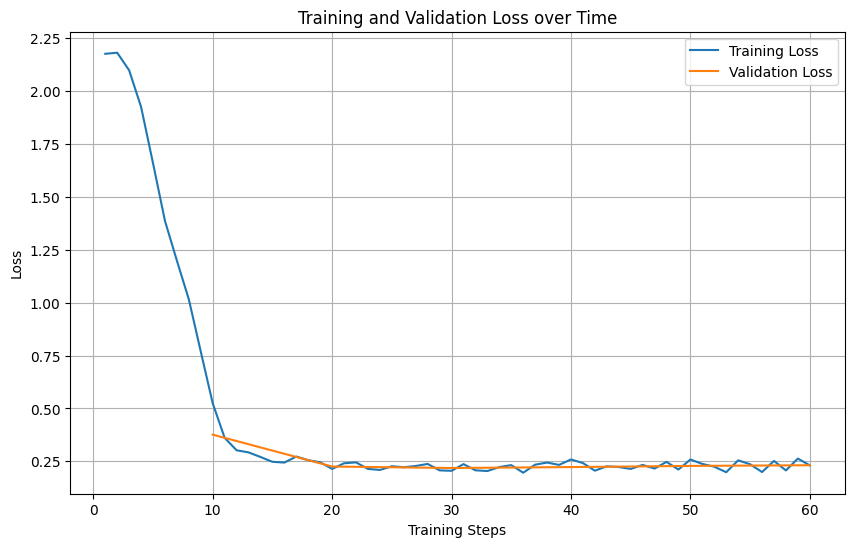

In [97]:

# Access the log history
log_history = trainer.state.log_history

# Convert to a DataFrame for easier handling
logs_df = pd.DataFrame(log_history)

# Filter out rows that contain training loss
train_loss = logs_df[logs_df["loss"].notnull()][["step", "loss"]]

# Filter out rows that contain evaluation loss
eval_loss = logs_df[logs_df["eval_loss"].notnull()][["step", "eval_loss"]]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.grid(True)
plt.show()


In [111]:
print(trainer.model)


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [112]:
# Q4_K_M version
model.push_to_hub_gguf(
    "terminAl-thesis-2025/Llama3.1-terminAl-8b-q4_k_m",
    tokenizer,
    quantization_method=["q4_k_m"],
    token=hf_token,
    private=True,
)

# Q5_K_M version
model.push_to_hub_gguf(
    "terminAl-thesis-2025/Llama3.1-terminAl-8b-q5_k_m",
    tokenizer,
    quantization_method=["q5_k_m"],
    token=hf_token,
    private=True,
)


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 24.42 out of 62.57 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 46.49it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at terminAl-thesis-2025/Llama3.1-terminAl-8b-q4_k_m into bf16 GGUF format.
The output location will be /home/m/PycharmProjects/thesis_playground/testscripts/terminAl-thesis-2025/Llama3.1-terminAl-8b-q4_k_m/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: Llama3.1-terminAl-8b-q4_k_m
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.flo

unsloth.Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/terminAl-thesis-2025/Llama3.1-terminAl-8b-q4_k_m
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 24.15 out of 62.57 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 46.04it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q5_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at terminAl-thesis-2025/Llama3.1-terminAl-8b-q5_k_m into bf16 GGUF format.
The output location will be /home/m/PycharmProjects/thesis_playground/testscripts/terminAl-thesis-2025/Llama3.1-terminAl-8b-q5_k_m/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: Llama3.1-terminAl-8b-q5_k_m
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.flo

unsloth.Q5_K_M.gguf:   0%|          | 0.00/5.73G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/terminAl-thesis-2025/Llama3.1-terminAl-8b-q5_k_m
